## Alineación

En esta primera parte obtendremos la imagen y sus 3 canales. También tendremos que aplicar pequeños cortes es la imagen para poder tenemos una imagen sin bordes de la original. Una vez tengamos los 3 canales podemos generar una imagen RGB para poder empezar la práctica.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


1.0 0.0


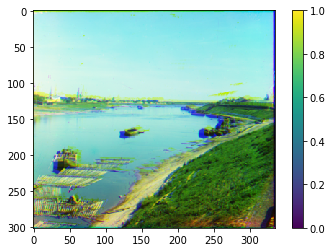

In [82]:
import numpy as np
from skimage import io, transform
from matplotlib import pyplot as plt
from skimage.exposure import equalize_hist
from PIL import Image
from scipy.misc import imresize

channels = Image.open('00029u.png')

def normalize_img(image):
    for i in range(image.shape[2]):
        image[:,:,i]=((image[:,:,i]-(np.min(image[:,:,i])))/((np.max(image[:,:,i]))-(np.min(image[:,:,i]))))
    return image

def getRGB(img):
    size1_size=int(round(img.size[1]/10))
    size2_size=int(round(img.size[0]/10))
    img = imresize(img, ( size1_size,size2_size), interp='bilinear').astype('float')
    img_np = np.array(img)
    x1 = 20; y1 = 20;
    x2 = 25; y2 = 333;
    x3 = 24; y3 = 647;
    w = 336; h = 302;
    im1 = img_np[y1-2:y1+h-2,x1-1:x1+w-1];
    im2 = img_np[y2-2:y2+h-2,x2-1:x2+w-1];
    im3 = img_np[y3-2:y3+h-2,x3-1:x3+w-1];
    I1 = (im1-np.min(im1))/(np.max(im1)-np.min(im1))
    I2 = (im2-np.min(im2))/(np.max(im2)-np.min(im2))
    I3 = (im3-np.min(im3))/(np.max(im3)-np.min(im3))
    RGB = np.dstack((I3, I2, I1))
    return RGB

img = getRGB(channels)
imgCopy = img.copy()
print(np.max(img), np.min(img))
plt.imshow(img)
plt.colorbar()
plt.show()

El bloque inferior obtiene un trozo de la imagen en el punto (140,165) con un padding de 15 para el canal de origen y 18 para los canales objetivos en los cuales se realizar la búsqueda mediante cross correlation. En este caso queremos que los canales G y B estén alineados con el canal R.

In [83]:
from scipy import ndimage, signal

def cross_image(im1, im2):
    im1 -= np.mean(im1)
    im2 -= np.mean(im2)
    return signal.correlate2d(im1,im2,mode="full",boundary="fill",fillvalue=0.01)
    #return signal.fftconvolve(im1, im2[::-1,::-1], mode='full')

def roll(img,dispX,dispY):
    
    copyX = img[:,0:-dispX]
    img = np.concatenate((img[:,-dispX:img.shape[1]],copyX),axis=1)
    
    copyY = img[0:-dispY,:]
    img2 = np.concatenate((img[-dispY:img.shape[0],:],copyY),axis=0)
    
    return img2

def crop(img, point, padding):
    return img[point[1]-padding:point[1]+padding, point[0]-padding:point[0]+padding]

point = (140,165)    
pad = 15

cropR = crop(img[:,:,0], point, pad)
cropG = crop(img[:,:,1], point, pad+3)
cropB = crop(img[:,:,2], point, pad+3)

Observamos la correlación entre los canales R y G

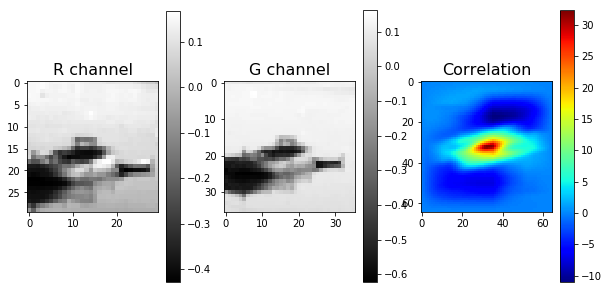

In [57]:
corrGR = cross_image(cropR, cropG)
#corrGR = corrGR - np.mean(corrGR)

fig, axarr = plt.subplots(ncols=3, nrows=1,figsize=(10,5))
pos1 = axarr[0].imshow(cropR, cmap='gray')
axarr[0].set_title('R channel', size=16)
pos2 = axarr[1].imshow(cropG, cmap='gray')
axarr[1].set_title('G channel', size=16)
pos3 = axarr[2].imshow(corrGR, cmap='jet')
axarr[2].set_title('Correlation', size=16)
fig.colorbar(pos1, ax=axarr[0])
fig.colorbar(pos2, ax=axarr[1])
fig.colorbar(pos3, ax=axarr[2])
plt.show()

Observamos la correlación entre los canales R y B

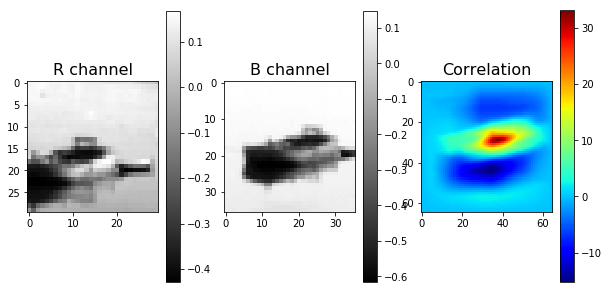

In [58]:
corrBR = cross_image(cropB, cropR)
#corrBR = corrBR - np.mean(corrBR)

fig, axarr = plt.subplots(ncols=3, nrows=1,figsize=(10,5))
pos1 = axarr[0].imshow(cropR, cmap='gray')
axarr[0].set_title('R channel', size=16)
pos2 = axarr[1].imshow(cropB, cmap='gray')
axarr[1].set_title('B channel', size=16)
pos3 = axarr[2].imshow(corrBR, cmap='jet')
axarr[2].set_title('Correlation', size=16)
fig.colorbar(pos1, ax=axarr[0])
fig.colorbar(pos2, ax=axarr[1])
fig.colorbar(pos3, ax=axarr[2])
plt.show()

Obtenemos cuando se han desplazado estos dos canales (G,B) respecto a R y procedemos a alinear estos canales. Para esto buscamos los puntos máximos de la correlación y el desplazamiento respecto al origen. Una vez obtenido estos podemos definir el desplazamiento aplicado al canal objetivo.

max corr:  32 33
shift:  (1, 0)
max corr:  29 37
shift:  (5, -3)


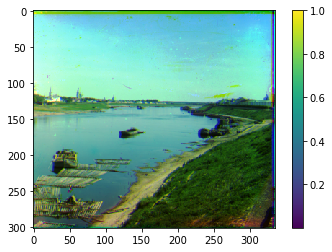

In [59]:
y, x = np.unravel_index(np.argmax(corrGR), corrGR.shape)
print("max corr: ", y, x)
despVector = (x-int(corrGR.shape[0]/2),y-int(corrGR.shape[1]/2))
print("shift: ", despVector)
newG = roll(imgCopy[:,:,1],-despVector[0],-despVector[1])

y, x = np.unravel_index(np.argmax(corrBR), corrBR.shape)
print("max corr: ", y, x)
despVector = (x-int(corrBR.shape[0]/2),y-int(corrBR.shape[1]/2))
print("shift: ", despVector)
newB = roll(imgCopy[:,:,2],-despVector[0],-despVector[1])

imgCopy[:,:,1] = newG
imgCopy[:,:,2] = newB

plt.imshow(equalize_hist(imgCopy))
plt.colorbar()
plt.show()

## Piramidal

Para la alineación piramidal necesitamos obtener un área de búsqueda más grande, pero esto puede ser muy costoso dependiendo del tamaño de la escala que quedemos obtener. En este caso buscaremos un área el doble de grande que la anterior, para obtener mejores resultados lo optimizaremos aplicando un filtro gaussiano y obteniendo un pixel cada X, donde X es la escala aplicada. Así obtendremos una imagen de búsqueda pequeña pero que abarca un área más grande en la imagen original. 

Se procede a seguir los mismos pasos que el ejercicio anterior y obtenemos resultados parecidos.

(30, 30) (30, 30) (30, 30)


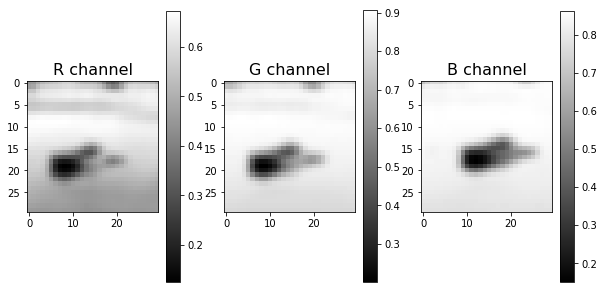

In [84]:
def gaussian(sigma = 9):
    y,x = np.ogrid[-(5*sigma+1)/2:(5*sigma+1)/2,-(5*sigma+1)/2:(5*sigma+1)/2]
    g = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    return g / g.sum()


def conv(img, fil):
    img_copy = np.array(img)
    img_copy = ndimage.convolve(img_copy, gaussian_filter, mode="constant",cval=0.0)
    return img_copy

point = (140,165)    
pad = 15
escala = 2
gaussian_filter = gaussian(sigma=escala)

cropR = crop(conv(img[:,:,0], gaussian_filter), point, pad*escala)[::escala, ::escala]
cropG = crop(conv(img[:,:,1], gaussian_filter), point, pad*escala)[::escala, ::escala]
cropB = crop(conv(img[:,:,2], gaussian_filter), point, pad*escala)[::escala, ::escala]

print(cropR.shape, cropG.shape, cropB.shape)

fig, axarr = plt.subplots(ncols=3, nrows=1,figsize=(10,5))
pos1 = axarr[0].imshow(cropR, cmap='gray')
axarr[0].set_title('R channel', size=16)
pos2 = axarr[1].imshow(cropG, cmap='gray')
axarr[1].set_title('G channel', size=16)
pos3 = axarr[2].imshow(cropB, cmap='gray')
axarr[2].set_title('B channel', size=16)
fig.colorbar(pos1, ax=axarr[0])
fig.colorbar(pos2, ax=axarr[1])
fig.colorbar(pos3, ax=axarr[2])
plt.show()

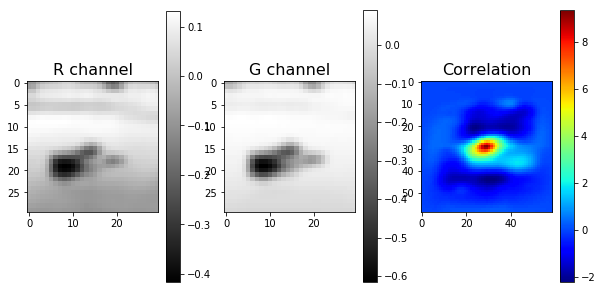

In [85]:
corrGR = cross_image(cropR, cropG)
#corrGR = corrGR - np.mean(corrGR)

fig, axarr = plt.subplots(ncols=3, nrows=1,figsize=(10,5))
pos1 = axarr[0].imshow(cropR, cmap='gray')
axarr[0].set_title('R channel', size=16)
pos2 = axarr[1].imshow(cropG, cmap='gray')
axarr[1].set_title('G channel', size=16)
pos3 = axarr[2].imshow(corrGR, cmap='jet')
axarr[2].set_title('Correlation', size=16)
fig.colorbar(pos1, ax=axarr[0])
fig.colorbar(pos2, ax=axarr[1])
fig.colorbar(pos3, ax=axarr[2])
plt.show()

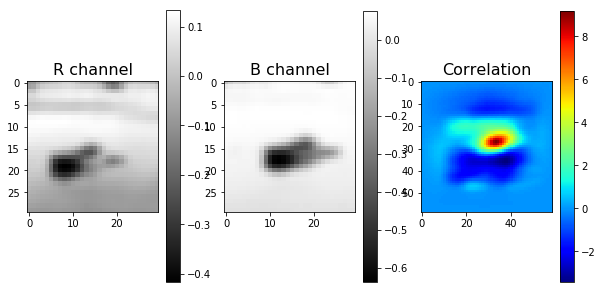

In [86]:
corrBR = cross_image(cropB, cropR)
#corrBR = corrBR - np.mean(corrBR)

fig, axarr = plt.subplots(ncols=3, nrows=1,figsize=(10,5))
pos1 = axarr[0].imshow(cropR, cmap='gray')
axarr[0].set_title('R channel', size=16)
pos2 = axarr[1].imshow(cropB, cmap='gray')
axarr[1].set_title('B channel', size=16)
pos3 = axarr[2].imshow(corrBR, cmap='jet')
axarr[2].set_title('Correlation', size=16)
fig.colorbar(pos1, ax=axarr[0])
fig.colorbar(pos2, ax=axarr[1])
fig.colorbar(pos3, ax=axarr[2])
plt.show()

max corr:  29 29
shift:  (0, 0)
max corr:  27 33
shift:  (4, -2)


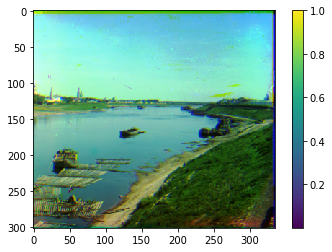

In [87]:
y, x = np.unravel_index(np.argmax(corrGR), corrGR.shape)
print("max corr: ", y, x)
despVector = (x-int(corrGR.shape[0]/2),y-int(corrGR.shape[1]/2))
print("shift: ", despVector)
newG = roll(imgCopy[:,:,1],-despVector[0],-despVector[1])

y, x = np.unravel_index(np.argmax(corrBR), corrBR.shape)
print("max corr: ", y, x)
despVector = (x-int(corrBR.shape[0]/2),y-int(corrBR.shape[1]/2))
print("shift: ", despVector)
newB = roll(imgCopy[:,:,2],-despVector[0],-despVector[1])

imgCopy[:,:,1] = newG
imgCopy[:,:,2] = newB

plt.imshow(equalize_hist(imgCopy))
plt.colorbar()
plt.show()